In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import print_function, division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import pandas as pd
import seaborn.apionly as sns
import matplotlib.ticker as ticker
import math
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import random as rand
# from sys import maxint
import scipy.stats as ss
import itertools
from itertools import islice, takewhile
import operator
from scipy.stats import t, cauchy, norm
from functools import reduce
import scipy
import pandas as pd

/home/mkhoshle/miniconda3/envs/research/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## States: 0:Inactive, 1:Active, 2:Dark, 3:Photo-Bleached

In [40]:
def transition_matrix(p):
    Q = np.array([[-0.1,0.1,0,0],[0,-0.1,0.0,0.1],[0,0,0,0],[0,0,0,0]])    # Rate Matrix (Hz)
    pi = scipy.linalg.expm(Q*np.float64(p))     
    # Transition Matrix exp(Qdt)        
    return pi # Unitless

In [41]:
def get_signal(pi,partitions):
    states = []
    state = 0 
    states.append(state)
    for i in range(1,len(partitions)-1):
        state = np.random.choice(4,p=pi[state])
#       state = 0 if i==0 else 3 if i==len(partitions)-1 else np.random.choice(4,p=pi[state_old])   
        states.append(state)   
    
    return states

In [42]:
# Total number of microstates (I,A,D,B)
def Generate_syntethic_data(step,pi,partitions,B,Miu_back,miu_bright,f,gain):                                                                     
    S = []                                                # State trajectory
    for i in range(B):
        print(i)
        S.append(get_signal(pi,partitions))
        
    S = pd.DataFrame(S)  
    Cs = np.where(S==1, 1,0)
    Cs = np.sum(Cs, axis=0)                               # Number of active particles vs time    
    N = np.shape(S)[1]                                    # Number of time levels
    # Calculate Observations (Noise)                                         
    Miu = pd.DataFrame(index=range(B),columns=range(N))   # Emission rate for each particle at time level n (photon/s)
    matches = S[(S==1)]
    # Get emission rate for each particle in time
    Miu = np.where(matches==1,miu_bright,0.0)        # Change in emission rate for each particle over time 
    tn = 0.95*step                                        # Total exposure time (s)    
    Wn = pd.Series(np.random.gamma(tn*(Miu_back+Miu.sum(axis=0))/f,scale=f*gain))
    return S, Cs, Wn, Miu

In [61]:
# Our time step is uniform: 
B = 10                         # Number of fluorphored particles
Miu_back = 5000               # Background photons emission rate (photon/s)
miu_bright = 3e+6             # Emission rate at the Bright state (photon/s)
gain = 10                     # gain
f = 2                         # Excess noise factor
step = 0.01                   # [S]
partitions = [i*step for i in range(round(100/step))]
# partitions = np.random.uniform(0,0.001,400000)

In [62]:
pi = transition_matrix(step)

In [63]:
pi

array([[9.99000500e-01, 9.99000500e-04, 0.00000000e+00, 4.99666792e-07],
       [0.00000000e+00, 9.99000500e-01, 0.00000000e+00, 9.99500167e-04],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [81]:
pi[0,0]

0.9990004998333749

In [80]:
pi[0,1]+pi[0,3]

0.0009995001666250082

In [77]:
np.sum(pi,axis=1)

array([1., 1., 1., 1.])

In [64]:
S, Cs, Wn, Miu = Generate_syntethic_data(step,pi,partitions,B,Miu_back,miu_bright,f,gain)

0
1
2
3
4
5
6
7
8
9


In [65]:
t = partitions

In [66]:
len(t[:-1])

9999

In [67]:
def plot_state(t,df):
    fig = plt.figure(figsize=(10,16)) 
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 12

    n = 0
    for i in range(len(df)):
        ax = fig.add_subplot(5,3,n+1)
        plt.step(x=t[:-1],y=S.iloc[i,:])
        if n % 3 == 0:
            ax.set_ylabel('State')
        if n>11:
            ax.set_xlabel('time (s)')
        ax.set_title(r'$particle-ID: {}$'.format(str(i)))
        ax.legend().set_visible(False)
        sns.despine(offset=12,ax=ax,trim=True)
        n = n+1

    # plt.subplots_adjust(top=0.92,bottom=0.08,left=0.1,right=0.95,wspace=0.6,hspace=0.6)
    plt.tight_layout()
    plt.show() 
    return None

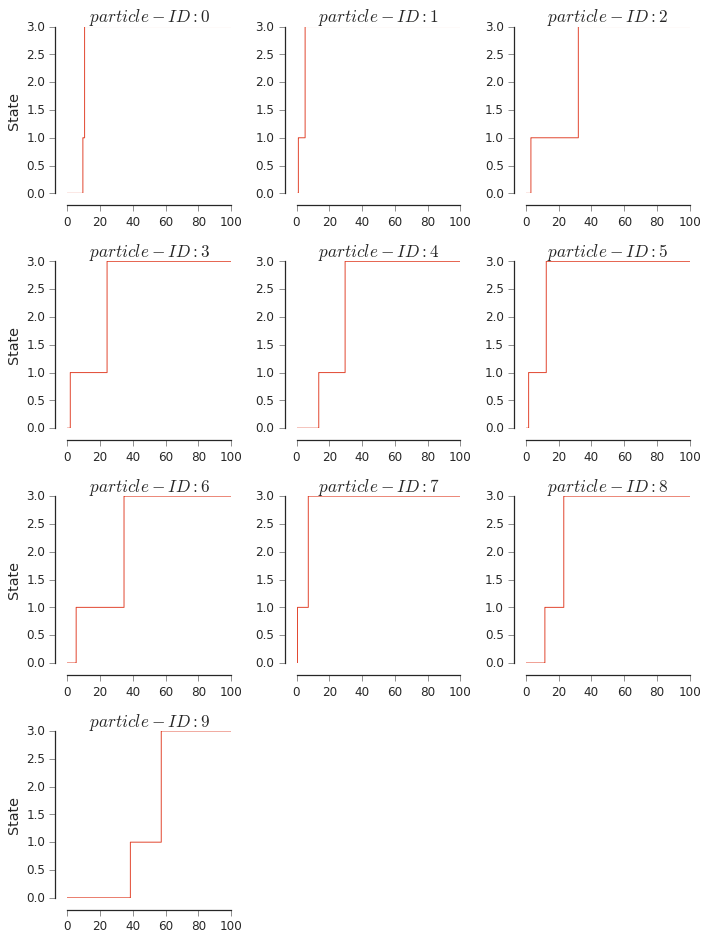

In [68]:
plot_state(t,S)

In [69]:
S.to_csv('trajectory_multiple_no_blinking2.csv')

In [70]:
def get_plot(df,xlabel,ylabel):
    fig = plt.figure(figsize=(4,4)) 
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 12
    plt.plot(t[:-1],df)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.tight_layout()
    sns.despine(offset=10)
    return None

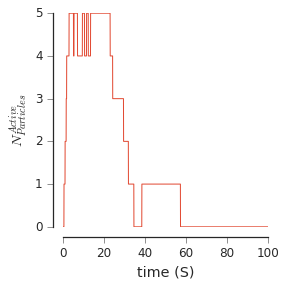

In [71]:
get_plot(Cs,'time (S)','$N^{Active}_{Particles}$')

In [72]:
# Mean Value of the Gamma Distribution
lambda_n = 0.95*step*(Miu_back+Miu.sum(axis=0))*gain

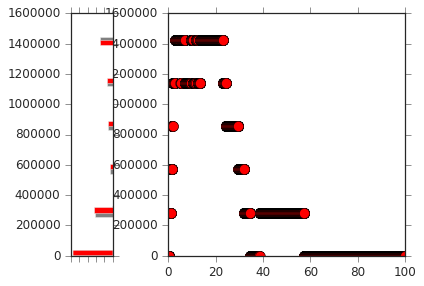

In [73]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.6, wspace=1.3)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
# x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(t[:-1], np.array(Wn), 'ok', markersize=3, alpha=0.9)
main_ax.plot(t[:-1],lambda_n, 'or', markersize=10, alpha=6.9) 

# histogram on the attached axes
# x_hist.hist(x, 40, orientation='vertical', color='gray')
# x_hist.invert_yaxis()

y_hist.hist(Wn, 40, orientation='horizontal', color='gray')
y_hist.hist(lambda_n, 40, orientation='horizontal', color='red')
y_hist.invert_xaxis()

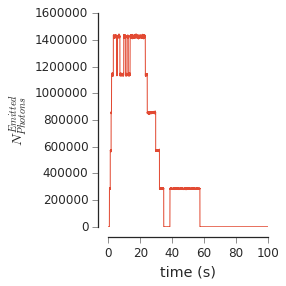

In [74]:
get_plot(Wn,'time (s)','$N^{Emitted}_{Photons}$')

In [75]:
out = pd.concat([pd.Series(t[:-1]),Wn],axis=1)

In [76]:
out.to_csv('observation_multiple_no_blinking2.csv')